# MSCA 31009 Final Project
### Author: Yifan Gao, Rajat Nagar
### Date:  August 26, 2021

## Import Libraries

In [2]:
import os, sys
from os.path import join, split, isdir, isfile, splitext, split, abspath, dirname
from PIL import Image
import numpy as np
import cv2
import shutil
import time
import datetime
import torch
from torch.utils import data
import torch.nn as nn
import torch.autograd.variable as Variable
import scipy.io as sio
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.conv import _single, _pair, _triple
from torch.optim.optimizer import Optimizer, required
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, sampler, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import matplotlib
import matplotlib.pyplot as plt
import random
from torch.utils.tensorboard import SummaryWriter

## Set up Folders & Parameters

In [3]:
# Define folder/path/file variables
# Root_dir = '/home/ygao26/Desktop/final'
Root_dir = '/storage/'
tmp_folder = 'tmpTIN/TIN' # tmp folder
data_folder = 'HED-BSDS' # root folder of dataset
test_lst = 'HED-BSDS/test.lst'
test_lst = join(Root_dir, test_lst) # test lst file
test_gt = join(Root_dir, 'HED-BSDS/gt/') # gt folder for test images
#test_pre = join(Root_dir, 'tmpRCF/RCF/epoch-10-testing-record-black') # predicted test sketches; modify accordingly
tmp_dir = join(Root_dir, tmp_folder) # tmp directory
if not isdir(tmp_dir):
    os.makedirs(tmp_dir)
    
# enable environment for GPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Define BSDS Data Loader Tool

In [4]:
from torch.utils import data
from os.path import join
from PIL import Image
import numpy as np
import cv2
#from matplotlib import pyplot as plt

# Convert image to CV2 format
def prepare_image_cv2(im):
    im = cv2.resize(im, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
    im = np.transpose(im, (2, 0, 1))  # (H x W x C) to (C x H x W)
    return im

class BSDS_Dataloader(data.Dataset):
    def __init__(self, root=data_folder, split='train', scale=None):
        self.root = root
        self.split = split
        self.scale = scale
        #self.bsds_root = join(root, 'HED-BSDS')
        if self.split == 'train':
            self.filelist = join(self.root, 'train_pair.lst')
        elif self.split == 'test':
            #self.filelist = join(self.bsds_root, 'image-test.lst')
            self.filelist = join(self.root, 'test.lst')
        else:
            raise ValueError("Invalid split type!")
        with open(self.filelist, 'r') as f:
            self.filelist = f.readlines()

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        r = np.random.randint(0, 100000)
        if self.split == "train":
            img_file, lb_file = self.filelist[index].split()
            lb = np.array(Image.open(join(self.root, lb_file)), dtype=np.float32)

            if lb.ndim == 3:
                lb = np.squeeze(lb[:, :, 0])
            assert lb.ndim == 2
            lb = cv2.resize(lb, (256, 256), interpolation=cv2.INTER_LINEAR)####

            lb = lb[np.newaxis, :, :]
            lb[lb == 0] = 0
            lb[np.logical_and(lb > 0, lb < 64)] = 2
            lb[lb >= 64] = 1
            # lb[lb >= 128] = 1
            img = np.array(cv2.imread(join(self.root, img_file)), dtype=np.float32)
            img = prepare_image_cv2(img)
            return img, lb
        else:
            img_file, lb_file = self.filelist[index].split()
            data = []
            data_name = []

            original_img = np.array(cv2.imread(join(self.bsds_root, img_file)), dtype=np.float32)
            img = cv2.resize(original_img, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)

            if self.scale is not None:
                for scl in self.scale:
                    img_scale = cv2.resize(img, None, fx=scl, fy=scl, interpolation=cv2.INTER_LINEAR)
                    data.append(img_scale.transpose(2, 0, 1))
                    data_name.append(img_file)
                return data, img, data_name

            img = prepare_image_cv2(img)

            lb = np.array(Image.open(join(self.bsds_root, lb_file)), dtype=np.float32)

            if lb.ndim == 3:
                lb = np.squeeze(lb[:, :, 0])
            assert lb.ndim == 2
            lb = cv2.resize(lb, (256, 256), interpolation=cv2.INTER_LINEAR)
            lb = lb[np.newaxis, :, :]
            lb[lb == 0] = 0
            lb[np.logical_and(lb > 0, lb < 64)] = 2
            lb[lb >= 64] = 1

            return img, lb, img_file

## Define Logger

In [5]:
import os, sys


class Logger(object):
    def __init__(self, fpath=None):
        self.console = sys.stdout
        self.file = None
        if fpath is not None:
            self.file = open(fpath, 'w')
    
    def __del__(self):
        self.close()
    
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        self.close()
        
    def write(self, msg):
        self.console.write(msg)
        if self.file is not None:
            self.file.write(msg)
    
    def flush(self):
        self.console.flush()
        if self.file is not None:
            self.file.flush()
            os.fsync(self.file.fileno())
    
    def close(self):
        self.console.close()
        if self.file is not None:
            self.file.close()

## Check The Images

In [6]:
batch_size=1
train_dataset = BSDS_Dataloader(root=join(Root_dir, data_folder), split= "train")
test_dataset = BSDS_Dataloader(root=join(Root_dir, data_folder),  split= "test")

In [7]:
#log = Logger('log.txt')
#sys.stdout = log

In [8]:
print('The size of test images is: ',len(test_dataset))
print('The size of train images and labels is: ', len(train_dataset)) 

The size of test images is:  50
The size of train images and labels is:  28800


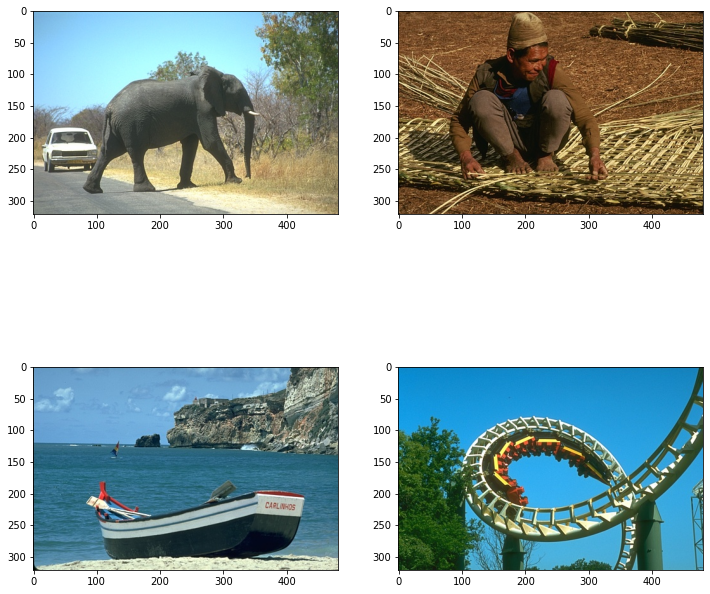

In [9]:
test_images_short = os.listdir(join(Root_dir, 'HED-BSDS/test/'))
test_images_short.sort()
test_images = list(map(lambda x: join(Root_dir, 'HED-BSDS/test/') + x, test_images_short))
fig = plt.figure(figsize=(12, 12))

for idx, img in enumerate(random.sample(test_images,4)):
    img = cv2.imread(img, 3)
    b,g,r = cv2.split(img)    
    img = cv2.merge([r,g,b])
    fig.add_subplot(2, 2, idx + 1)
    plt.imshow(img)
plt.show()

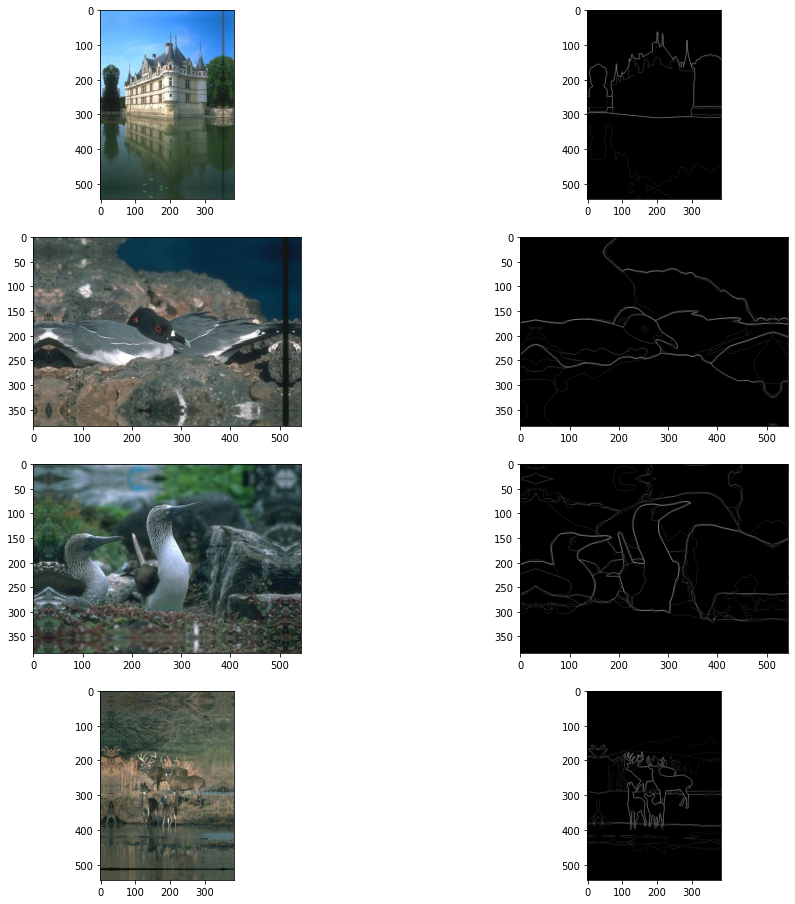

In [10]:
train_images_short = os.listdir(join(Root_dir, 'HED-BSDS/train/aug_data/0.0_1_0/'))
train_images_short.sort()
train_images = list(map(lambda x: join(Root_dir, 'HED-BSDS/train/aug_data/0.0_1_0/') + x, train_images_short))
train_labels_short = os.listdir(join(Root_dir, 'HED-BSDS/train/aug_gt/0.0_1_0/'))
train_labels_short.sort()
train_labels = list(map(lambda x: join(Root_dir, 'HED-BSDS/train/aug_gt/0.0_1_0/') + x, train_labels_short))
fig = plt.figure(figsize=(16, 16))

for idx, img in enumerate(zip(train_images[5:9], train_labels[5:9])):
    img1 = cv2.imread(img[0], 3)
    b,g,r = cv2.split(img1)    
    img1 = cv2.merge([r,g,b])
    img2 = cv2.imread(img[1], 3)
    b,g,r = cv2.split(img2)    
    img2 = cv2.merge([r,g,b])
    fig.add_subplot(4, 2, idx * 2 + 1)
    plt.imshow(img1)
    fig.add_subplot(4, 2, idx * 2 + 2)
    plt.imshow(img2)
plt.show()

## Define Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class Enrichment(nn.Module):
    def __init__(self, c_in, rate=2):
        super(Enrichment, self).__init__()
        self.rate = rate
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(c_in, 32, 3, stride=1, padding=1)
        dilation = self.rate*1 if self.rate >= 1 else 1
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, dilation=dilation, padding=dilation)
        dilation = self.rate*2 if self.rate >= 1 else 1
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, dilation=dilation, padding=dilation)
        dilation = self.rate*3 if self.rate >= 1 else 1
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, dilation=dilation, padding=dilation)
        dilation = self.rate * 4 if self.rate >= 1 else 1
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, dilation=dilation, padding=dilation)
        self._initialize_weights()

    def forward(self, x):
        o = self.relu(self.conv(x))
        o1 = self.relu(self.conv1(o))
        o2 = self.relu(self.conv2(o))
        o3 = self.relu(self.conv3(o))
        o4 = self.relu(self.conv4(o))
        out = o + o1 + o2 + o3 + o4
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
                if m.bias is not None:
                    m.bias.data.zero_()


class TIN(nn.Module):
    def __init__(self,pretrain=False,tin_m=2):
        super(TIN, self).__init__()
        self.tin_m = tin_m
        ## CONV stage 1
        self.conv1_1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1)

        self.em1_1 = Enrichment(16, 4)
        self.em1_2 = Enrichment(16, 4)
            # CONV DOWN
        self.conv1_1_down = nn.Conv2d(32, 8, 1, padding=0)
        self.conv1_2_down = nn.Conv2d(32, 8, 1, padding=0)
            # SCORE
        self.score_stage1 = nn.Conv2d(8, 1, 1)
            # RELU
        self.relu = nn.ReLU()

        if tin_m > 1:
            ## CONV stage 2
            self.conv2_1 = nn.Conv2d(16, 64, 3, padding=1)
            self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)

            self.em2_1 = Enrichment(64, 4)
            self.em2_2 = Enrichment(64, 4)
                # CONV DOWN
            self.conv2_1_down = nn.Conv2d(32, 8, 1, padding=0)
            self.conv2_2_down = nn.Conv2d(32, 8, 1, padding=0)
                # SCORE
            self.score_stage2 = nn.Conv2d(8, 1, 1)

            # POOL
            self.maxpool = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # pooling biasa
            self.score_final = nn.Conv2d(2, 1, 1)

        if pretrain:
            state_dict = torch.load(pretrain)
            own_state_dict = self.state_dict()
            for name, param in own_state_dict.items():
                if name in state_dict:
                    print('copy the weights of %s from pretrained model' % name)
                    param.copy_(state_dict[name])
                else:
                    print('init the weights of %s from mean 0, std 0.01 gaussian distribution'\
                         % name)
                    if 'bias' in name:
                        param.zero_()
                    else:
                        if 'BN' in name:
                            param.zero_()
                        else:
                            param.normal_(0, 0.01)
        else:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        # =========================================
        conv1_1 = self.relu(self.conv1_1(x))
        conv1_2 = self.relu(self.conv1_2(conv1_1))
        # =========================================
        conv1_1_down = self.conv1_1_down(self.em1_1(conv1_1))
        conv1_2_down = self.conv1_2_down(self.em1_2(conv1_2))
        # =========================================
        o1_out = self.score_stage1(conv1_1_down + conv1_2_down)
        # =========================================
        if self.tin_m > 1:
            pool1 = self.maxpool(conv1_2)
            # =========================================
            conv2_1 = self.relu(self.conv2_1(pool1))
            conv2_2 = self.relu(self.conv2_2(conv2_1))
            # =========================================
            conv2_1_down = self.conv2_1_down(self.em2_1(conv2_1))
            conv2_2_down = self.conv2_2_down(self.em2_2(conv2_2))
            # =========================================
            o2_out = self.score_stage2(conv2_1_down + conv2_2_down)
            # =========================================
            upsample2 = nn.UpsamplingBilinear2d(size=(h, w))(o2_out)
            # =========================================
            fuseout = torch.cat((o1_out, upsample2), dim=1)
            fuse = self.score_final(fuseout)
            results = [o1_out, upsample2, fuse]
            results = [torch.sigmoid(r) for r in results]
        else:
            results = [o1_out]
            results = [torch.sigmoid(r) for r in results]
        return results

## Utility Functions

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_img(dat,rows,columns,fname):
    w=10
    h=10
    #fig, axarr = plt.figure(figsize=(8, 8))
    d,_,_ = dat.shape
    print(d)
    counter = 0
    f, axarr = plt.subplots(rows, columns)
    for r in range(rows):
        for c in range(columns):
            axarr[r, c].imshow(dat[counter], cmap='gray')
            axarr[r, c].axis('off')
            counter = counter + 1
    plt.savefig(fname, bbox_inches='tight')


def init_model(model):
    shape = (3, 3)
    a = np.array([custom_kernel(shape,0),
                 custom_kernel(shape, 22.5),
                 custom_kernel(shape,45),
                 custom_kernel(shape, 67.5),
                 custom_kernel(shape,90),
                 custom_kernel(shape, 112.5),
                 custom_kernel(shape,135),
                 custom_kernel(shape, 157.5),
                 custom_kernel(shape,180),
                 custom_kernel(shape, 202.5),
                 custom_kernel(shape,225),
                 custom_kernel(shape, 247.5),
                 custom_kernel(shape,270),
                 custom_kernel(shape, 292.5),
                 custom_kernel(shape,315),
                 custom_kernel(shape, 337.5),])

    a = np.array([a, a, a])
    a = np.transpose(a, (1, 0, 2, 3))
    model.conv1_1.weight.data = torch.from_numpy(a).float()

def custom_sobel(shape, axis):
    """
    shape must be odd: eg. (5,5)
    axis is the direction, with 0 to positive x and 1 to positive y
    """
    k = np.zeros(shape)
    p = [(j,i) for j in range(shape[0])
           for i in range(shape[1])
           if not (i == (shape[1] -1)/2. and j == (shape[0] -1)/2.)]

    for j, i in p:
        j_ = int(j - (shape[0] -1)/2.)
        i_ = int(i - (shape[1] -1)/2.)
        k[j,i] = (i_ if axis==0 else j_)/float(i_*i_ + j_*j_)
    return k


def custom_kernel(shape,deg):
    k = custom_sobel(shape, deg)
    kd = k
    for i in range(shape[0]):
        for j in range(shape[1]):
            kd[i, j] = np.cos(np.deg2rad(deg)) * k[i, j] + np.sin(np.deg2rad(deg)) * k[i, j]

    return kd

class Averagvalue(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train

In [13]:
import os, sys
from os.path import join
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter

"""
learning rate adjustment div by 10 every 10 epochs
"""
def adjust_learning_rate(optimizer, epoch):
    lr = 1e-2 * (0.1 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def make_optimizer(model, lr):
    optim = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    return optim

def save_img_progress(results, filename):
    if not os.path.isdir('img_log'):
        os.mkdir('img_log')

    results_all = torch.zeros((len(results), 1, 256, 256))
    # print(results[0].shape)
    for i in range(len(results)):
        results_all[i, 0, :, :] = results[i][0]
    torchvision.utils.save_image(1 - results_all, join('img_log', "%s.jpg" % filename))

def save_ckpt(model, name):
    print('saving checkpoint ... {}'.format(name), flush=True)
    if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
    torch.save(model.state_dict(), os.path.join('checkpoints', '{}.pth'.format(name)))

"""
balance cross entropy 
"""
def balanced_cross_entropy_loss(prediction, label):
    label = label.long()
    mask = label.float()
    num_positive = torch.sum((mask == 1).float()).float()
    num_negative = torch.sum((mask == 0).float()).float()

    mask[mask == 1] = 1.0 * num_negative / (num_positive + num_negative)
    mask[mask == 0] = 1.1 * num_positive / (num_positive + num_negative)
    mask[mask == 2] = 0

    cost = torch.nn.functional.binary_cross_entropy(
        prediction.float(), label.float(), weight=mask, reduce=False)
    return torch.sum(cost) / (num_negative + num_positive)

In [14]:
"""
CREATE TRAIN/VALIDATION SPLIT AND PREPARE DATASET
"""
validation_split = 0.2
shuffle_dataset = True
random_seed= 42

filelist = join(Root_dir, data_folder, 'train_pair.lst')
# loop thru whole list of images and labels
with open(filelist, 'r') as f:
    filelist = f.readlines()
    # Create data indices for training and validation splits
dataset_size = len(filelist)

indices = list(range(dataset_size))
split_idx = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split_idx:], indices[:split_idx]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler,
    num_workers=8, drop_last=True)

val_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=8, drop_last=True)

In [15]:
"""
create model
"""
model = TIN(False,2)
init_model(model)
model.cuda()
model.train()

TIN(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (em1_1): Enrichment(
    (relu): ReLU(inplace=True)
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dilation=(8, 8))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12))
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(16, 16), dilation=(16, 16))
  )
  (em1_2): Enrichment(
    (relu): ReLU(inplace=True)
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(8, 8), dil

In [16]:
"""
PARAMS
"""
init_lr = 1e-2
total_epoch = 15
#####
each_epoch_iter = len(train_loader)
total_iter = total_epoch * each_epoch_iter
#####
print_cnt = 1000
ckpt_cnt = 10000
cnt = 0
avg_loss = 0.
avg_val_loss = 0.
batch_time = Averagvalue()
end = time.time()

writer = SummaryWriter()
optim = make_optimizer(model, init_lr)

print('*' * 60)
print('train images in all are %d ' % each_epoch_iter)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('total params in all are %d ' % pytorch_total_params)
print('*' * 60)

************************************************************
train images in all are 23040 
total params in all are 244229 
************************************************************


In [ ]:
"""
START TRAINING
"""
log = Logger('log.txt')
sys.stdout = log

print('*' * 60)
print('train images in all are %d ' % each_epoch_iter)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('total params in all are %d ' % pytorch_total_params)
print('*' * 60)

global train_loss, train_loss_detail, val_loss, val_loss_detail
# train/val loss parameters
train_loss = []
train_loss_detail = []
val_loss = []
val_loss_detail = []
losses_tr = Averagvalue()
losses_val = Averagvalue()
epoch_loss_tr = []
epoch_loss_val = []
    
for epoch in range(total_epoch):
    for i, (image, label) in enumerate(train_loader):
        cnt += 1
        if epoch % 10 == 0:
            adjust_learning_rate(optim, epoch)

        image, label = image.cuda(), label.cuda()
        outs = model(image)
        total_loss = 0

        for each in outs:
            total_loss += balanced_cross_entropy_loss(each, label)/batch_size

        optim.zero_grad()
        total_loss.backward()
        optim.step()

        avg_loss += float(total_loss)
        
        losses_tr.update(total_loss.item(), image.size(0))
        epoch_loss_tr.append(avg_loss)
        
        batch_time.update(time.time() - end)
        end = time.time()
        if cnt % print_cnt == 0:
            writer.add_scalar('Loss/train', avg_loss / print_cnt, cnt)
            #print('[{}/{}] loss:{} avg_loss: {}'.format(cnt, total_iter, float(total_loss), avg_loss / print_cnt), 
            #      flush=True)
            info = 'Epoch: [{0}/{1}][{2}/{3}] '.format(epoch + 1, total_epoch, i+1, each_epoch_iter) + \
                   'Time {batch_time.val:.3f} (avg:{batch_time.avg:.3f}) '.format(batch_time=batch_time) + \
                   'loss:{} avg_loss:{}'.format(float(total_loss), avg_loss / print_cnt)
            print(info, flush=True)
            avg_loss = 0
            save_img_progress(outs, 'iter-{}'.format(cnt))

        if cnt % ckpt_cnt == 0:
            save_ckpt(model, 'weight-{}-iter-{}'.format(init_lr, cnt))

    tr_avg_loss = losses_tr.avg
    tr_detail_loss = epoch_loss_tr
    
    model.eval()
    for i, (image, label) in enumerate(val_loader):
        image, label = image.cuda(), label.cuda()
        
        outs = model(image)
        
        total_val_loss = 0

        for each in outs:
            total_val_loss += balanced_cross_entropy_loss(each, label)/batch_size
        
        avg_val_loss += float(total_val_loss)
        
        losses_val.update(total_val_loss.item(), image.size(0))
        epoch_loss_val.append(avg_val_loss)
        
    val_avg_loss = losses_val.avg
    val_detail_loss = epoch_loss_val
    
    train_loss.append(tr_avg_loss)
    train_loss_detail += tr_detail_loss
    val_loss.append(val_avg_loss)
    val_loss_detail += val_detail_loss
    
    log.flush()

save_ckpt(model, 'final-model')

************************************************************
train images in all are 23040 
total params in all are 244229 
************************************************************


/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [1/15][1000/23040] Time 0.073 (avg:0.097) loss:0.046453531831502914 avg_loss:0.12091400986956433
Epoch: [1/15][2000/23040] Time 0.073 (avg:0.085) loss:0.20162442326545715 avg_loss:0.1102323441435583
Epoch: [1/15][3000/23040] Time 0.074 (avg:0.081) loss:0.03098202496767044 avg_loss:0.10224192776437849
Epoch: [1/15][4000/23040] Time 0.071 (avg:0.079) loss:0.09853315353393555 avg_loss:0.09425955113908276
Epoch: [1/15][5000/23040] Time 0.071 (avg:0.078) loss:0.13414104282855988 avg_loss:0.09047835309780203
Epoch: [1/15][6000/23040] Time 0.071 (avg:0.077) loss:0.0779559463262558 avg_loss:0.09280893492745236
Epoch: [1/15][7000/23040] Time 0.073 (avg:0.077) loss:0.09149543941020966 avg_loss:0.08814368021581322
Epoch: [1/15][8000/23040] Time 0.072 (avg:0.076) loss:0.1642341911792755 avg_loss:0.08666444604331627
Epoch: [1/15][9000/23040] Time 0.075 (avg:0.076) loss:0.051756687462329865 avg_loss:0.08395249828929081
Epoch: [1/15][10000/23040] Time 0.075 (avg:0.076) loss:0.1181039810180664 

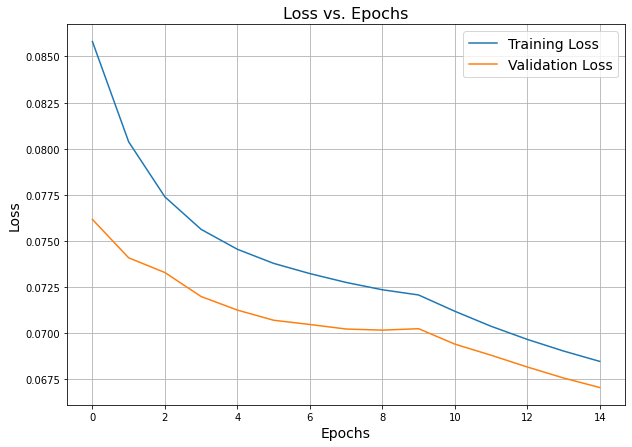

In [ ]:
# Plot train and validation loss
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Loss vs. Epochs', fontsize=16)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

In [ ]:
"""
START TEST
"""
import os
test_images_short = os.listdir(join(Root_dir, 'HED-BSDS/test/'))
test_images_short.sort()
test_images = list(map(lambda x: join(Root_dir, 'HED-BSDS/test/') + x, test_images_short))

model = TIN(False,2)
model.cuda()
model.eval()

for imgs in test_images:
    #test_img = 'img/mri_brain.jpg'
    ## READ IMAGE
    im = np.array(cv2.imread(imgs), dtype=np.float32)
    ## Multiscale
    scales = [0.5,1.0,1.5]
    images = []
    for scl in scales:
        img_scale = cv2.resize(im, None, fx=scl, fy=scl, interpolation=cv2.INTER_LINEAR)
        images.append(img_scale.transpose(2, 0, 1)) # (H x W x C) to (C x H x W)

    ## CREATE MODEL
    weight_file = '/notebooks/checkpoints/final-model.pth'
    #load weight
    checkpoint = torch.load(weight_file)
    model.load_state_dict(checkpoint)

    ## FEED FORWARD
    h, w, _ = im.shape
    ms_fuse = np.zeros((h, w))

    with torch.no_grad():
        for img in images:
            img = img[np.newaxis, :, :, :]
            img = torch.from_numpy(img)
            img = img.cuda()
            out = model(img)
            fuse = out[-1].squeeze().detach().cpu().numpy()
            fuse = cv2.resize(fuse, (w, h), interpolation=cv2.INTER_LINEAR)
            ms_fuse += fuse
        ms_fuse /= len(scales)

        if not os.path.isdir('img'):
            os.mkdir('img')
        
        strt=imgs.rfind("/")+1
        filename = imgs[strt:-4]
    
        result = Image.fromarray(255-(ms_fuse * 255).astype(np.uint8))
        result.save( "img/%s.png" % filename)
print('finished.')

finished.


In [ ]:
from edges_eval_dir import edges_eval_dir

In [ ]:
test_pre = '/notebooks/img/'
test_gt = join(Root_dir, 'HED-BSDS/gt/')
edges_eval_dir(test_pre, test_gt)

0/50 eval /notebooks/img/296028.png...
1/50 eval /notebooks/img/120003.png...
2/50 eval /notebooks/img/107045.png...
3/50 eval /notebooks/img/226022.png...
4/50 eval /notebooks/img/156054.png...
5/50 eval /notebooks/img/2018.png...
6/50 eval /notebooks/img/49024.png...
7/50 eval /notebooks/img/100039.png...
8/50 eval /notebooks/img/259060.png...
9/50 eval /notebooks/img/384089.png...
10/50 eval /notebooks/img/246009.png...
11/50 eval /notebooks/img/257098.png...
12/50 eval /notebooks/img/3063.png...
13/50 eval /notebooks/img/163096.png...
14/50 eval /notebooks/img/189029.png...
15/50 eval /notebooks/img/388067.png...
16/50 eval /notebooks/img/187099.png...
17/50 eval /notebooks/img/268074.png...
18/50 eval /notebooks/img/104055.png...
19/50 eval /notebooks/img/123057.png...
20/50 eval /notebooks/img/94095.png...
21/50 eval /notebooks/img/289011.png...
22/50 eval /notebooks/img/118015.png...
23/50 eval /notebooks/img/393035.png...
24/50 eval /notebooks/img/130066.png...
25/50 eval /note

In [ ]:
import pandas as pd
# Show ODS OIS scores for RCF and enhanced RCF models
perf_tin = pd.read_csv("/notebooks/img/-eval/eval_bdry.txt", header=None, delimiter=' ')
perf_tin = perf_tin[[3, 6]]
perf_tin.columns = ["ODS", "OIS"]
perf_tin.index = ["TIN"]
perf_tin

,ODS,OIS
TIN,0.320437,0.363315


## Image Examples for Presentation

In [30]:
import torch
import os
from os.path import join
import numpy as np
from PIL import Image
import scipy.io as io
import cv2
import time

test_img = '/storage/HED-BSDS/test/196027.jpg'
## READ IMAGE
im = np.array(cv2.imread(test_img), dtype=np.float32)
## Multiscale
scales = [0.5,1.0,1.5]
images = []
for scl in scales:
    img_scale = cv2.resize(im, None, fx=scl, fy=scl, interpolation=cv2.INTER_LINEAR)
    images.append(img_scale.transpose(2, 0, 1)) # (H x W x C) to (C x H x W)

## CREATE MODEL
#weight_file = '/notebooks/checkpoints/weight-0.01-iter-30000.pth'
weight_file = '/notebooks/checkpoints/final-model.pth'
model = TIN(False,2)
model.cuda()
model.eval()
#load weight
checkpoint = torch.load(weight_file)
model.load_state_dict(checkpoint)

## FEED FORWARD
h, w, _ = im.shape
ms_fuse = np.zeros((h, w))

with torch.no_grad():
    for img in images:
        img = img[np.newaxis, :, :, :]
        img = torch.from_numpy(img)
        img = img.cuda()
        out = model(img)
        fuse = out[-1].squeeze().detach().cpu().numpy()
        fuse = cv2.resize(fuse, (w, h), interpolation=cv2.INTER_LINEAR)
        ms_fuse += fuse
    ms_fuse /= len(scales)
    
    if not os.path.isdir('examples'):
            os.mkdir('examples')

    filename = '196027-Final'
    result = Image.fromarray(255-(ms_fuse * 255).astype(np.uint8))
    result.save( "examples/%s.png" % filename)
print('finished.')

finished.


**Ground Truth Images**

In [31]:
gt_img_dir = '/storage/HED-BSDS/gt/'
if not isdir(gt_img_dir):
    os.makedirs(gt_img_dir)
    
for filename in os.listdir(test_gt):
    data = sio.loadmat(join(test_gt,filename))
    edge_data = data['groundTruth'][0][0][0][0][1]
    #Store the normalized data: 0<x<1
    #So need to restore back to 0<x<255
    edge_data_255 = Image.fromarray((edge_data * 255).astype(np.uint8))
    new_img_name = filename.split('.')[0]+'.png'
    edge_data_255.save(join(gt_img_dir, new_img_name))

## References:

https://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter5.pdf

https://github.com/jannctu/TIN

J. K. Wibisono and H. -M. Hang, "Traditional Method Inspired Deep Neural Network For Edge Detection," 2020 IEEE International Conference on Image Processing (ICIP), 2020, pp. 678-682, doi: 10.1109/ICIP40778.2020.9190982.

https://pytorch.org/docs/stable/index.html

https://github.com/Walstruzz/edge_eval_python​

https://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter5.pdf

https://www.cse.unr.edu/~bebis/CS791E/Notes/EdgeDetection.

https://github.com/Walstruzz/edge_eval_python/archive/refs/heads/main.zip

http://mftp.mmcheng.net/liuyun/rcf/data/HED-BSDS.tar.gz

http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz